# Introduction to CyberGIS-Compute


**Authors:** Alexander Michels, Taylor Ziegler, Zimo Xiao, Mit Kotak, Anand Padmanabhan, Zhiyu Li, and Shaowen Wang

This notebook serves a simple introduction to CyberGIS-Compute by walking through two spatial accessibility models. 

The first model is a relatively simple one which could be run within CyberGISX (the Jupyter interface you're in right now): calculating accessibility to doctors in Chicago, Illinois, U.S. using multiple metrics with the [Pysal Access package](https://pysal.org/access/index.html). We will run the model with CyberGIS-Compute, then download the results from the HPC, and calculate correlations between the metrics. The model serves to explain what a CyberGIS-Compute model looks like and gain some familiarity with CyberGIS-Compute.

The second model is more complex and cannot be done within CyberGISX: calculating travel-time catchments for hospitals in Illinois using a road network from [OpenStreetMap](https://www.openstreetmap.org/) and using them to calculate spatial accessibility to hospital ventilators for the entire state of Illinois, U.S. The model uses code from the publication ["Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA"](https://doi.org/10.1186/s12942-020-00229-x). This model uses parallelization across 4 CPUs and utilizes 64-80GB of memory when executing which far exceeds the resources available in Jupyter and most personal computers.  The model demonstrates the capabilities of CyberGIS-Compute.

## Table of Contents

* [What is Spatial Accessibility](#spatial-access)
* [Data Exploration](#data-explore)
* [Access with CyberGIS-Compute](#compute-job)
* [Analyzing the Outputs](#analysis)
* [Compute with Larger Jobs](#big-compute)
* [Learn More about CyberGIS-Compute](#learn-more)

In [1]:
# !pip install access

In [2]:
from access import Access, weights, Datasets  # the Pysal access package
import contextily as cx
from cybergis_compute_client import CyberGISCompute
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd

/tmp/ipykernel_3706/2078517168.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
# useful variables
chfigsize = (8, 10)  # used for maps of Chicago, adjust as you see fit!3

<hr id="spatial-access" />

## What is Spatial Accessibility?

Before we jump into the analysis, let's briefly explain what spatial accessibility is! Access is a complex and hard to measure concept (see [Penchansky and Thomas (1981)](http://www.jstor.org/stable/3764310)), but we will try to measure **place-based spatial accessibility.** These measures attempt to capture the spatial impedance (distance, travel-time, etc.) between supply and demand and the relationship between the volumes of supply and demand across space. A simple example using hospitals and calculated travel-time catchments can be seen in the image below:

![Measuring Access](img/MeasuringAccess.webp)

*Image from "Kang, JY., Michels, A., Lyu, F. et al. Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA. Int J Health Geogr 19, 36 (2020). [https://doi.org/10.1186/s12942-020-00229-x](https://doi.org/10.1186/s12942-020-00229-x)"*

This is of course a simplistic approach and the literature contains a variety of more complex methods which we will begin to explore in this notebook!

<hr id="data-explore" />

## Data Exploration

In this section of the notebook, we will briefly look at Pysal example data before submitting our job using [CyberGIS-Compute](https://cybergis.github.io/cybergis-compute-python-sdk/). Pysal Access has a variety of datasets available:

In [4]:
Datasets.available_datasets()


chi_times: Cost matrix with travel times from each Chicago Census Tract to all others.

chi_doc: Doctor and dentist counts for each Chicago Census Tract.

chi_pop: Population counts for each Chicago Census Tract.

chi_doc_geom: Doctor and dentist counts for each Chicago Census Tract along with geometric representations for Census Tracts.

chi_pop_geom: Population counts for each Chicago Census Tract along with geometric representations for Census Tracts.

chi_euclidean: Euclidean distance cost matrix with distances from each demand Chicago Census Tract to all others.

chi_euclidean_neighbors: Euclidean distance cost matrix with distances from each supply Census Tract to all others.

cook_county_hospitals: Contains data for each hospital location in Cook County including X Y coordinates.

cook_county_hospitals_geom: Contains data for each hospital location in Cook County including X Y coordinates, and geometric points for each hospital.

cook_county_tracts: Geometric representation of 

We will start with the population data:

In [5]:
chicago_pop = Datasets.load_data("chi_pop")
chicago_pop.head()

geoid   pop
0  17031010100  4854
1  17031010201  6450
2  17031010202  2818
3  17031010300  6236
4  17031010400  5042

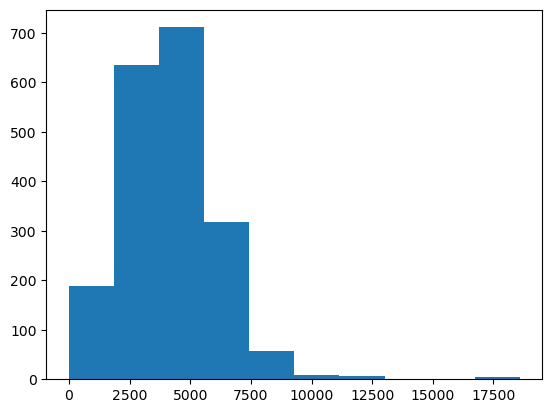

In [6]:
plt.hist(chicago_pop["pop"])
plt.show()

We need to load a geometry to map this data. Luckily, that data is also available through pysal access:

GEO_ID STATE COUNTY   TRACT  NAME   LSAD  CENSUSAREA  \
0  1400000US17031440300    17    031  440300  4403  Tract       0.499   
1  1400000US17031440600    17    031  440600  4406  Tract       0.259   
2  1400000US17031440700    17    031  440700  4407  Tract       0.126   
3  1400000US17031460200    17    031  460200  4602  Tract       0.232   
4  1400000US17031460600    17    031  460600  4606  Tract       0.101   

         geoid                                           geometry  
0  17031440300  POLYGON ((359779.998 563694.900, 359785.854 56...  
1  17031440600  POLYGON ((359797.310 563086.247, 359800.394 56...  
2  17031440700  POLYGON ((360201.128 563098.184, 360402.583 56...  
3  17031460200  POLYGON ((364927.536 564034.757, 365032.657 56...  
4  17031460600  POLYGON ((364641.501 563219.094, 364699.974 56...

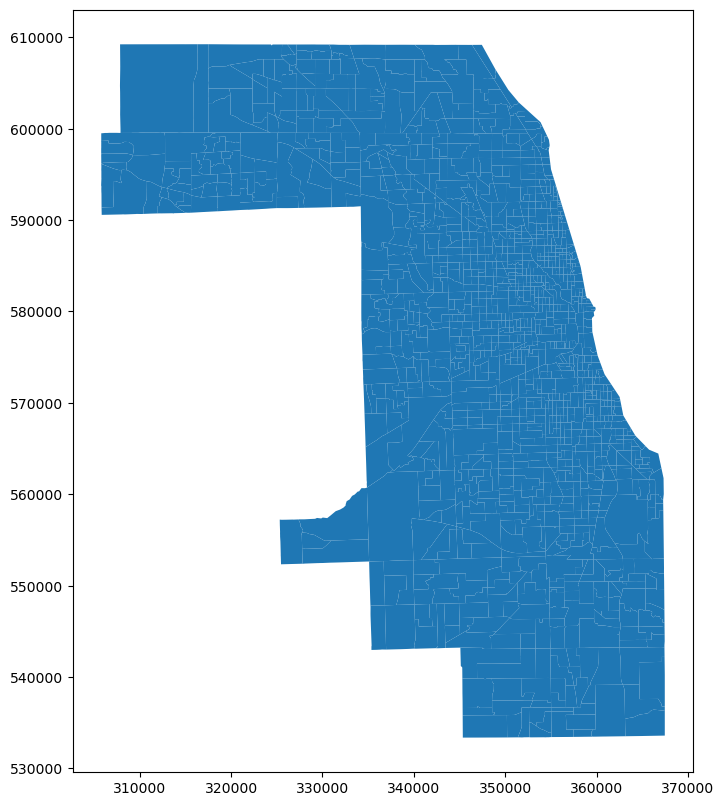

In [7]:
cook_tracts = Datasets.load_data("cook_county_tracts")
cook_tracts.plot(figsize=chfigsize)
cook_tracts.head()

Let's merge the population Dataframe to the census tract GeoDataFrame. They share a field "geoid", so we can use that:

In [8]:
cook_pop = cook_tracts.merge(chicago_pop, on="geoid")
cook_pop.head()

GEO_ID STATE COUNTY   TRACT  NAME   LSAD  CENSUSAREA  \
0  1400000US17031440300    17    031  440300  4403  Tract       0.499   
1  1400000US17031440600    17    031  440600  4406  Tract       0.259   
2  1400000US17031440700    17    031  440700  4407  Tract       0.126   
3  1400000US17031460200    17    031  460200  4602  Tract       0.232   
4  1400000US17031460600    17    031  460600  4606  Tract       0.101   

         geoid                                           geometry   pop  
0  17031440300  POLYGON ((359779.998 563694.900, 359785.854 56...  4757  
1  17031440600  POLYGON ((359797.310 563086.247, 359800.394 56...  2080  
2  17031440700  POLYGON ((360201.128 563098.184, 360402.583 56...  1545  
3  17031460200  POLYGON ((364927.536 564034.757, 365032.657 56...  2385  
4  17031460600  POLYGON ((364641.501 563219.094, 364699.974 56...  1183

Let's visualize and explore our data:

In [9]:
cook_pop.explore(column="pop")

That give us our demand data! We also need some kind of supply data to use for the accessibility analysis. Let's use the Chicago doctor data with the geometry. According to the description from the `Datasets.available_datasets()` output, this gives us:

> Doctor and dentist counts for each Chicago Census Tract along with geometric representations for Census Tracts.

In [10]:
chi_doc = Datasets.load_data("chi_doc_geom")
chi_doc.head()

geoid  doc  dentist                       geometry
0  17031010100    1        1  POINT (354916.992 594670.505)
1  17031010201    0        1  POINT (354105.876 594088.600)
2  17031010202    4        1  POINT (354650.684 594093.822)
3  17031010300    4        1  POINT (355209.361 594086.149)
4  17031010400    0        2  POINT (355809.748 592808.043)

We will use (and visualize) the doctor information:

In [11]:
chi_doc.explore(column="doc")

Lastly, we need travel-time information. The pysal access package has a Chicago travel-time matrix available:

In [12]:
chi_times = Datasets.load_data('chi_times')
chi_times.head()

origin         dest   cost
0  17093890101  17031010100  91.20
1  17093890101  17031010201  92.82
2  17093890101  17031010202  92.95
3  17093890101  17031010300  89.40
4  17093890101  17031010400  84.97

Let's try plotting travel-times from a single destination. We will plot the source in red and the rest of the census tracts in blue:

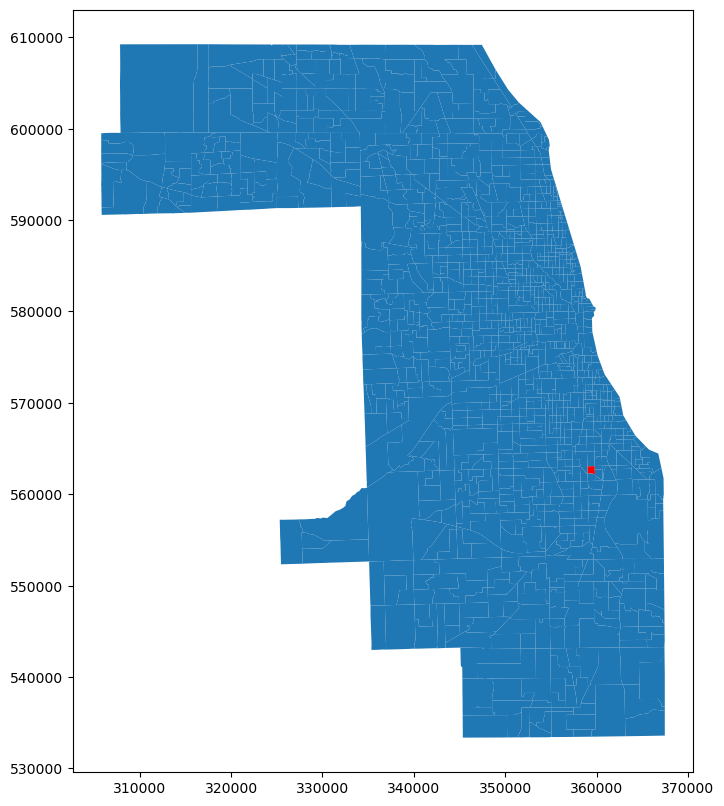

In [13]:
source = 17031440600  # the one destination we will plot costs from
ax = cook_tracts[cook_tracts["geoid"] == source].plot(color="red", figsize=chfigsize)
cook_tracts[~(cook_tracts["geoid"] == source)].plot(ax=ax)
plt.show()

Now, we want to isolate just the costs from the source:

In [14]:
just_source = chi_times[chi_times["origin"] == source]
print(f"There are {len(just_source)} census tracts.")
just_source.head()

There are 2063 census tracts.


origin         dest   cost
1312659  17031440600  17031010100  44.98
1312660  17031440600  17031010201  46.25
1312661  17031440600  17031010202  43.68
1312662  17031440600  17031010300  43.18
1312663  17031440600  17031010400  38.75

...and then merge the costs to a copy of the census tract GeoDataFrame:

In [15]:
dists_from_source = cook_tracts.copy(deep=True)
dists_from_source = dists_from_source.merge(just_source, left_on="geoid", right_on="dest")
dists_from_source.head()

GEO_ID STATE COUNTY   TRACT  NAME   LSAD  CENSUSAREA  \
0  1400000US17031440300    17    031  440300  4403  Tract       0.499   
1  1400000US17031440600    17    031  440600  4406  Tract       0.259   
2  1400000US17031440700    17    031  440700  4407  Tract       0.126   
3  1400000US17031460200    17    031  460200  4602  Tract       0.232   
4  1400000US17031460600    17    031  460600  4606  Tract       0.101   

         geoid                                           geometry  \
0  17031440300  POLYGON ((359779.998 563694.900, 359785.854 56...   
1  17031440600  POLYGON ((359797.310 563086.247, 359800.394 56...   
2  17031440700  POLYGON ((360201.128 563098.184, 360402.583 56...   
3  17031460200  POLYGON ((364927.536 564034.757, 365032.657 56...   
4  17031460600  POLYGON ((364641.501 563219.094, 364699.974 56...   

        origin         dest   cost  
0  17031440600  17031440300   4.97  
1  17031440600  17031440600   0.43  
2  17031440600  17031440700   3.08  
3  17031440600  17031460200  22.38  
4  17031440600  17031460600  19.02

Now we can visualize it!

In [16]:
dists_from_source.explore(column="cost")

<hr id="compute-job" />

## Access with CyberGIS-Compute

Now that we have examined our data, let's run the Chicago accessibility job on CyberGIS-Compute. First, we will break down the core components of the job starting with the manifest:

In [17]:
!cat manifest.json

{
    "name": "Pysal Access Example",
    "description": "Calculates spatial accessibility using a variety of metrics using the Pysal access package: https://github.com/pysal/access",
    "estimated_runtime": "3-6 minutes",
    "container": "pysal-access",
    "execution_stage": "python ChicagoAccess.py",
    "slurm_input_rules": {
           "time": {
                "max": 30,
                "min": 15,
                "default_value": 20,
                "step": 1,
                "unit": "Minutes"   
            },
            "memory": {
                "max": 4,
                "min": 2,
                "default_value": 4,
                "step": 1,
                "unit": "GB"
            }
    },
    "require_upload_data": false,
    "supported_hpc": ["anvil_community", "expanse_community", "keeling_community"],
    "default_hpc": "keeling_community"
}


The manifest gives basic information on the job: name, container to run the job in, the steps of the job (pre_processing_stage, executation_stage, and post-processing_stage), etc.

The "container" is a self-contained environment that we can run code within. This means that models run on CyberGIS-Compute should work consistently across HPC resources!

The main steps from the job are:

* "pre_processing_stage": "bash install_access.sh",
* "execution_stage": "python ChicagoAccess.py",
* "post_processing_stage": "ls",

The post_processing_stage just lists the files, so the important parts are the pre_processing_stage and executation_stage. Let's check those out:

In [18]:
!cat install_access.sh

cat: install_access.sh: No such file or directory


This is pretty simple: it just installs the Pysal access package with pip!

Now, we can look at the ChicagoAccess.py which does the actual computation:

In [19]:
!cat ChicagoAccess.py

#!/usr/bin/env python
# coding: utf-8

# In[1]:


import pandas as pd
import geopandas as gpd
from access import Access, weights, Datasets
import os


# In[2]:

RESULTS_FOLDER = os.getenv('result_folder')
print(f"The results folder is: {RESULTS_FOLDER}")

print("Hit the beginning of ChicagoAccess.py")
# Datasets.available_datasets()


# In[3]:


chicago_pop = Datasets.load_data("chi_pop")


# In[4]:


chi_doc = Datasets.load_data("chi_doc_geom")


# In[5]:


chi_times = Datasets.load_data('chi_times')
print("All data loaded successfully")

# In[6]:


A = Access(demand_df            = chicago_pop,
           demand_index         = 'geoid',
           demand_value         = 'pop',
           supply_df            = chi_doc,
           supply_index         = 'geoid',
           supply_value         = 'doc',
           cost_df              = chi_times,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'cost',
           n

The file is a bit long, but let's break it down cell-by-cell:

1. Imports packages
2. Gets the results folder from the environment
3. Loads the population dataset from access
4. Loads the doctor dataset from access
5. Loads the travel-times dataset from access
6. Creates a `pysal.access.Access` object
7. Creates weights objects for our calculations.
8. Calculates a variety of accessibility metrics.
9. Prints the result dataframes's head.
10. Saves the result dataframe to the results path as a CSV.

The file was created from the [ChicagoAccess.ipynb](ChicagoAccess.ipynb) notebook, with some added code (print statements and getting the results folder) after it was exported.

### Running the Job

Now that we've looked over the job, let's run it! The cell below imports the cybergis_compute_client and connects us to our job server:

In [20]:
cybergis = CyberGISCompute(url="cgjobsup.cigi.illinois.edu", isJupyter=True, protocol="HTTPS", port=443, suffix="v2")

For a bit more detail here:

* `url` is the URL of our CyberGIS-Compute Core server.
* `isJupyter` means that we are in a Jupyter environment and can use widgets.
* `protocol` tells us to speak to the Core server over the HTTPS protocol.
* `port` tells us which port to talk to the Core server on.
* `suffix` helps us specify the version of the Core to talk to. We currently have a legacy version ("v1") and the current version ("v2").

We will next use the `show_ui()` function to pull up the CyberGIS-Compute user interface. From the `Job Templates` dropdown, select `pysal-access` and then click the "Submit Job" button at the bottom:

In [21]:
cybergis.show_ui()

🎯 Logged in as michels9@illinois.edu@jupyter.iguide.illinois.edu


Once the job is submitted, the UI should automatically change tabs to the "Your Job Status". The job takes a few minutes to run because it is installing pysal/access and running the analysis. 

The "job events" section should give you updates on your job though. You should see it being:

* queued (in the queue of our CyberGIS-Compute Core),
* registered (sent to the HPC resource),
* init (started running),
* and then finally ended.

Once the job ends, go to the "Download Job Result" tab. Under the "select file/f..." dropdown, select "/" (this should be the default).  Then click the "Download" button. This will download the results through [Globus](https://www.globus.org/). When the download finishes, you should see:

>✅ download success!

>please check your data at your root folder under "globus_download_xxxxxxxxxxxxxxx"

You can copy/paste that path, or we can fetch the path from `cybergis.recentDownloadPath`.

If for some reason your kernel restarts or the job is no longer showing, you can go to the "Your Jobs" tab and restore it. Under the "exectuableFolder" (the job template) look for "git://pysal-access".

In [22]:
download_path = cybergis.recentDownloadPath
print(f"Our outputs are at {download_path}")

Our outputs are at /home/jovyan/globus_download_1719935102Q0739


Let's `ls` the path to see what is there:

In [23]:
!ls {download_path}

access_result.csv  slurm_log


The `slurm_log` folder has our SLURM job logs:

In [24]:
!ls {download_path}/slurm_log/

job.stderr  job.stdout


Feel free to navigate to this path in the file browser to check out the slurm logs for yourself! If you find the following in `job.stderr`, that is ok, you can safely ignore it:
    
>ModuleCmd_Use.c(231):ERROR:64: Directory 'gnu/openmpi-4.1.2-gnu-4.8.5' not found
WARNING: The directory '/home/jovyan/.cache/pip' or its parent directory is not owned or is not writable by the current user. The cache has been disabled. Check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
/data/keeling/a/cigi-gisolve/.local/lib/python3.7/site-packages/access/fca.py:130: UserWarning: some tracts may be unaccounted for in supply_cost
  warnings.warn("some tracts may be unaccounted for in supply_cost", stacklevel = 1)
access INFO     :: Overwriting fca_doc.


<hr id="analysis" />

## Analyzing the Outputs

Let's load the output and start plotting/analyzing!

In [25]:
path_to_load = os.path.join(download_path, "access_result.csv")
print(f"Reading from {path_to_load}...")
result = pd.read_csv(path_to_load)
result.head()

Reading from /home/jovyan/globus_download_1719935102Q0739/access_result.csv...


geoid   pop   gravity_doc   fca_doc  fca60_doc  fca90_doc  2sfca_doc  \
0  17031010100  4854  10618.895243  0.001640   0.001098   0.000922   0.000697   
1  17031010201  6450  10801.211105  0.001536   0.001083   0.000910   0.000754   
2  17031010202  2818  11324.424819  0.001521   0.001071   0.000914   0.000717   
3  17031010300  6236  10535.149629  0.001573   0.001091   0.000916   0.000703   
4  17031010400  5042  10934.394373  0.001551   0.001054   0.000911   0.000743   

   2sfca30_doc  2sfca60_doc  g2sfca_doc  3sfca_doc  raam_doc  raam30_doc  
0     0.000980     0.000688    0.000765   0.001447  0.888102    1.027597  
1     0.001094     0.000751    0.000820   0.001487  0.857214    0.940239  
2     0.001030     0.000719    0.000800   0.001420  0.897102    1.031144  
3     0.001031     0.000709    0.000791   0.001479  0.961906    1.071731  
4     0.000910     0.000788    0.000876   0.001274  1.041687    1.317185

You will see a variety of accessibility metrics! For convenience, I have copied the weights and accessibility cells from the job below:
```
fn30 = weights.step_fn({10 : 1, 20 : 0.68, 30 : 0.22})
fn60 = weights.step_fn({20 : 1, 40 : 0.68, 60 : 0.22})
gaussian = weights.gaussian(20)
gravity = weights.gravity(scale = 60, alpha = -1)

print("Beginning Accessibility calculations")
A.weighted_catchment    (name = "gravity",  weight_fn = gravity)
A.fca_ratio             (name = "fca",      max_cost = 15)
A.fca_ratio             (name = "fca",      max_cost = 30)
A.fca_ratio             (name = "fca60",    max_cost = 60)
A.fca_ratio             (name = "fca90",    max_cost = 90)
A.two_stage_fca         (name = "2sfca",    max_cost = 60)
A.enhanced_two_stage_fca(name = "2sfca30",  weight_fn = fn30)
A.enhanced_two_stage_fca(name = "2sfca60",  weight_fn = fn60)
A.enhanced_two_stage_fca(name = "g2sfca",   weight_fn = gaussian)
A.three_stage_fca       (name = "3sfca")
A.raam(name = "raam", tau = 60)
A.raam(name = "raam30", tau = 30)
```

It is convenient to merge these outputs to our census tract GeoDataFrame for plotting purposes:

GEO_ID STATE COUNTY   TRACT  NAME   LSAD  CENSUSAREA  \
0  1400000US17031440300    17    031  440300  4403  Tract       0.499   
1  1400000US17031440600    17    031  440600  4406  Tract       0.259   
2  1400000US17031440700    17    031  440700  4407  Tract       0.126   
3  1400000US17031460200    17    031  460200  4602  Tract       0.232   
4  1400000US17031460600    17    031  460600  4606  Tract       0.101   

         geoid                                           geometry   pop  ...  \
0  17031440300  POLYGON ((359779.998 563694.900, 359785.854 56...  4757  ...   
1  17031440600  POLYGON ((359797.310 563086.247, 359800.394 56...  2080  ...   
2  17031440700  POLYGON ((360201.128 563098.184, 360402.583 56...  1545  ...   
3  17031460200  POLYGON ((364927.536 564034.757, 365032.657 56...  2385  ...   
4  17031460600  POLYGON ((364641.501 563219.094, 364699.974 56...  1183  ...   

    fca_doc  fca60_doc  fca90_doc  2sfca_doc  2sfca30_doc  2sfca60_doc  \
0  0.001038   0.000961   0.000898   0.001002     0.001093     0.001167   
1  0.001035   0.000958   0.000898   0.000993     0.001205     0.001162   
2  0.001032   0.000968   0.000900   0.000954     0.000939     0.001082   
3  0.001132   0.001009   0.000917   0.000837     0.000394     0.000753   
4  0.001064   0.000981   0.000910   0.000869     0.000533     0.000840   

   g2sfca_doc  3sfca_doc  raam_doc  raam30_doc  
0    0.001234   0.000782  1.176927    1.354383  
1    0.001264   0.000810  1.252700    1.487897  
2    0.001077   0.000778  1.293301    1.836704  
3    0.000629   0.000614  1.208118    1.410876  
4    0.000730   0.000678  1.221609    1.491280  

[5 rows x 21 columns]

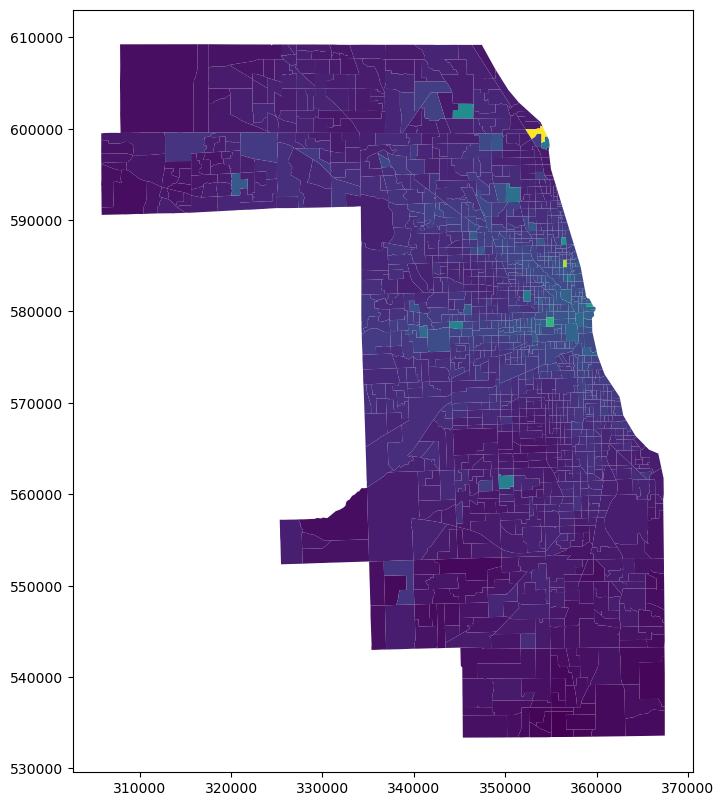

In [26]:
result_gdf = cook_tracts.copy(deep=True)
result_gdf = result_gdf.merge(result, on="geoid")
result_gdf.plot(column="gravity_doc", figsize=chfigsize)
result_gdf.head()

How do these measures compare? Let's calculate and visualize the correlations!

In [27]:
corr = result_gdf[["gravity_doc","fca_doc", "fca60_doc", "fca90_doc", "2sfca_doc", "2sfca30_doc",
                   "2sfca60_doc", "g2sfca_doc", "3sfca_doc", "raam_doc", "raam30_doc"]].corr()

In [28]:
corr.style.background_gradient(cmap='coolwarm')

We see that many of the metrics are positively correlated (for example, the two RAAM measures (`raam_doc` and `raam30_doc`), but we also see some of the metrics are strongly negatively correlated. Clearly, it's important that we choose our spatial accessibility metrics carefully and fully understand them, because different metrics tell completely different stories!

<hr id="big-compute" />

## Compute with Larger Jobs

The spatial accessibility calculation performed above is relatively simple: you can use the [ChicagoAccess.ipynb](ChicagoAccess.ipynb) notebook to perform the same analysis in Jupyter without using CyberGIS-Compute. However, CyberGIS-Compute allows you to tackle bigger problems and gives you a larger array of computational resources. 

* As of this writing, users on CyberGISX have access to 2 CPUs and up to 4GB of memory.
* A typical personal computer generally has in the range of 2-8 CPUs and 4-32GB of memory. 
* The Keeling supercomputer we are using has hundreds of nodes with up to 48 CPUs and ~250GB of memory.

CyberGIS-Compute is also compatible with HPC resources around the world and is currently connected to the [Expanse](https://www.sdsc.edu/services/hpc/expanse/) supercomputer and [Bridges-2](https://www.psc.edu/resources/bridges-2/). These resources provide access to massive amounts of CPU, memory, storage and even GPUs!

Let's look at a model which couldn't be run in CyberGISX: calculating spatial accessibility to hospital ventilators across Illinois ([Github repo here](https://github.com/cybergis/cybergis-compute-spatial-access-covid-19)). This job is much more computationally intensive than our Chicago example for two key reasons:

1. We are performing the calculation for a much larger geographic extent (Illinois vs. Chicago which a city in Illinois)
2. The Chicago example had pre-computed travel-times which is the most computationally intensive part of spatial accessibility analysis! For our next model, we will use [OpenStreetMap (OSM)](https://www.openstreetmap.org/) road network data for the state of Illinois to calculate travel-time catchments around hospitals and then calculate spatial accessibility with this data. 

The model uses code from the following publication:

> Kang, JY., Michels, A., Lyu, F. et al. Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA. Int J Health Geogr 19, 36 (2020). https://doi.org/10.1186/s12942-020-00229-x

Let's pull up the CyberGIS-Compute UI and run the model. In the "Job Templates" dropdown, select "covid-access". As the description says, the job uses 4CPUs and between 64 and 80GB of memory. When you are ready, submit the job.

**Note:** This job takes about 20 minutes to run and the cells after it rely on the job's results.

In [ ]:
cybergis.show_ui()

**Wait for the job to finish to run more cells. These cells all depend on the results of the job!**

When the job finishes, go to the "Download Job Result" tab and select "/" from the dropdown (it should be the default choice). Then click the "Download" button and wait for the download to finish.

Once the download is finished, you can run the cell below to get the download path:

In [ ]:
download_path = cybergis.recentDownloadPath
print(f"Our outputs are at {download_path}")

Let's list the stuff we downloaded from the HPC resource:

In [ ]:
!ls {download_path}

Now, let's load the result GeoJSON object:

In [ ]:
result_path = os.path.join(download_path, "result.geojson")
gdf = gpd.read_file(result_path)
gdf.head()

We can plot the spatial accessibility output with the cell below:

In [ ]:
ax = gdf.plot(column="hospital_vents", cmap="OrRd", figsize=(8,10), legend=True)
cx.add_basemap(ax, crs=gdf.crs.to_string())

...or we can create an interactive visualization with the geopandas `explore` function:

In [ ]:
gdf.explore(column="hospital_vents", cmap="OrRd")

<hr id="learn-more" />

## Learn More about CyberGIS-Compute

You can learn a lot about the CyberGIS-Compute project on the [CyberGIS-Compute Python SDK page](https://cybergis.github.io/cybergis-compute-python-sdk/index.html), especially on the [About page](https://cybergis.github.io/cybergis-compute-python-sdk/about.html) which has YouTube presentations and papers for you to view!

* For a step-by-step guide on using CyberGIS-Compute, we have a ["Using CyberGIS-Compute" guide](https://cybergis.github.io/cybergis-compute-python-sdk/usage.html) which walks you through running our "Hello World" CyberGIS-Compute job.
* Check out our [Model Gallery](https://cybergis.github.io/cybergis-compute-python-sdk/models.html) to see the models which are currently being used on CyberGIS-Compute.
* Those hoping to contribute models to CyberGIS-Compute should check out our ["Contributing Models" guide](https://cybergis.github.io/cybergis-compute-python-sdk/model_contribution/index.html).

The [ContributingAModel.ipynb](ContributingAModel.ipynb) notebook is another useful guide for learning how to contribute a model with CyberGIS-Compute!